Now that we have a dataset, some models and a sliding window, let's found the cars

Text(0.5, 1.0, 'Image and associated HOG feature')

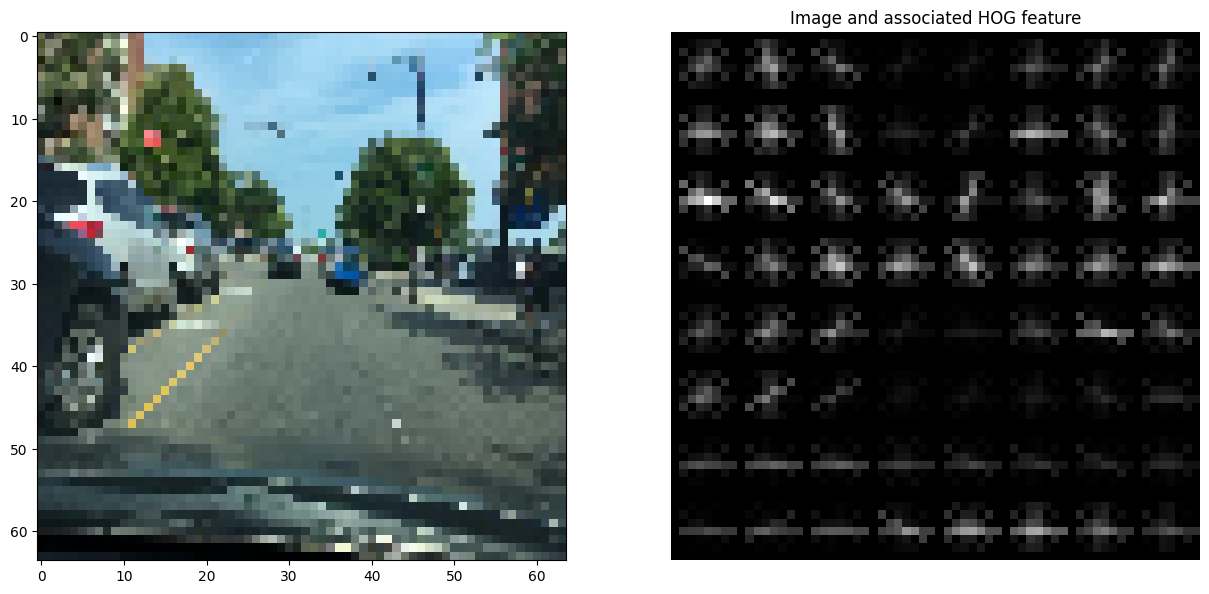

In [4]:
from skimage.feature import hog
import matplotlib.pyplot as plt
import cv2


image = cv2.imread("train/A_001.jpg")
image = image[:,:,::-1]
image = cv2.resize(image,(64,64))
# Creating hog features with dummy parameters
fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
    cells_per_block=(2, 2), visualize=True,channel_axis=-1)
    
# plotting
fig, ax = plt.subplots(1,2, figsize= (15,15))
ax[0].imshow(image)
ax[1].axis("off")
ax[1].imshow(hog_image, cmap="gray")
plt.title("Image and associated HOG feature")

/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


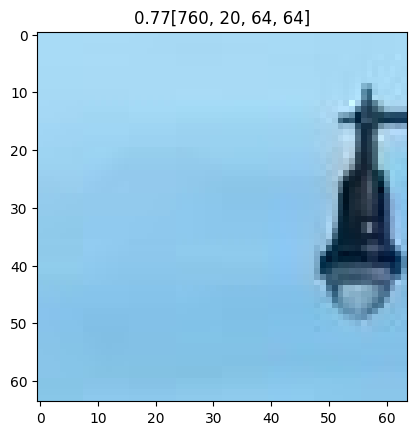

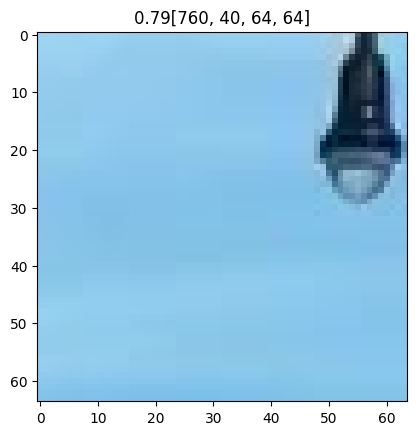

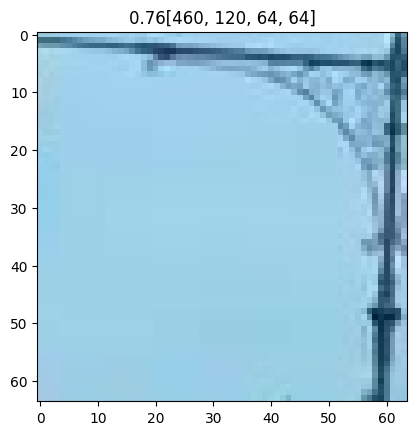

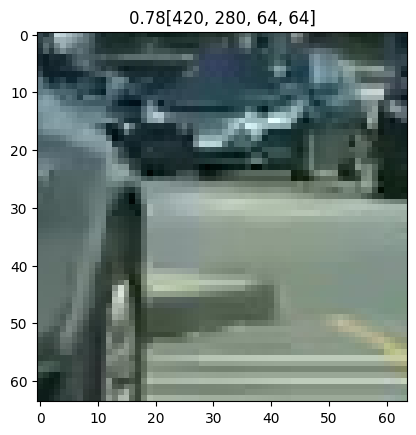

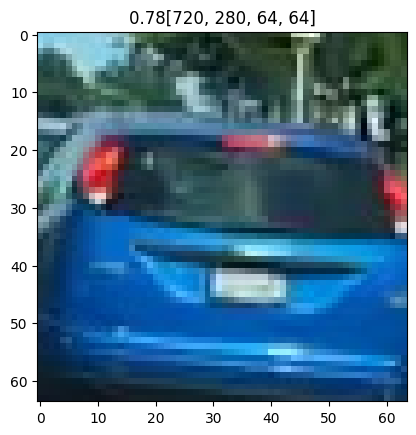

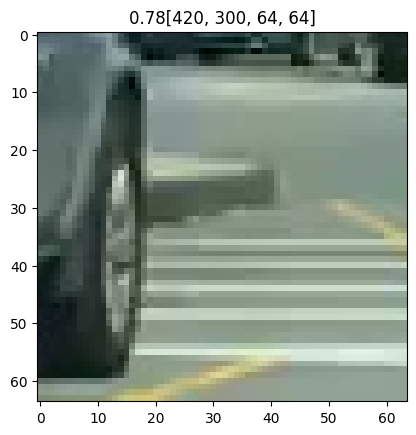

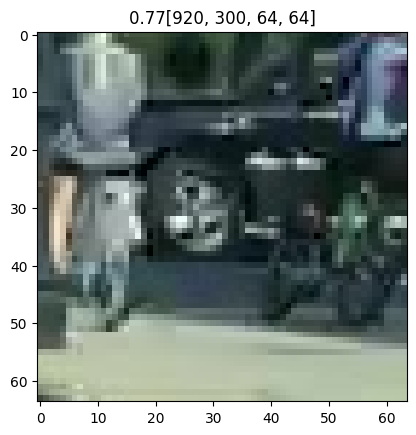

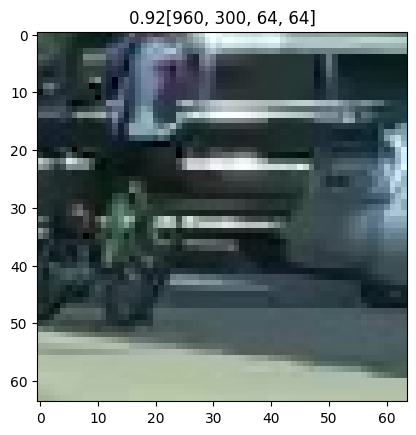

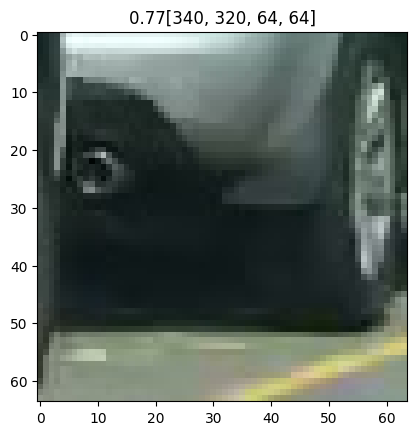

In [50]:
from utils import sliding_window
import numpy as np
import pickle

MODEL_PATH = "models/randomforest.model"
model = pickle.load(open(MODEL_PATH, "rb"))
image = cv2.imread("train/A_001.jpg")[:,:,::-1]

boxes = []

for window, coords in sliding_window(image):
    fd, hog_image = hog(window, orientations=9, pixels_per_cell=(8, 8),
    cells_per_block=(2, 2), visualize=True,channel_axis=-1)

    fd = fd.reshape(-1, 1)
    fd = np.transpose(fd,(1,0))
    
    proba = model.predict_proba(fd)

    # If there is likely a car, print it
    if proba[0][1] > 0.75:
        plt.title(str(proba[0][1])+ str([coords[0],coords[1], coords[2], coords[3]]))
        plt.imshow(window)
        plt.show()
        boxes += [coords[0],coords[1] , coords[2], coords[3]]

#### Plot bounding boxes 

In [51]:
from ipywidgets import interact, widgets
from IPython.display import display
from utils import create_bounding_boxes_df
from instruction_utils import show_annotation

df_boxes = create_bounding_boxes_df(boxes)

def f_display(frame_id):
    show_annotation(df_boxes, frame_id)

interact(f_display, frame_id=widgets.IntSlider(min=0, max=N-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='frame_id', max=2221), Output()), _dom_classes=('widget-i…

<function __main__.f_display(frame_id)>

In [54]:
def overlap(box1, box2, threshold=0.5):
    """
    Determine if two boxes overlap based on their intersection over union (IoU).
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    if x1 >= x2 or y1 >= y2:
        return False
    intersection = (x2 - x1) * (y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = intersection / float(area1 + area2 - intersection)
    return iou >= threshold


[(760, 20, 64, 84), (460, 120, 64, 64), (420, 280, 64, 84), (720, 280, 64, 64), (920, 300, 104, 64), (340, 320, 64, 64)]


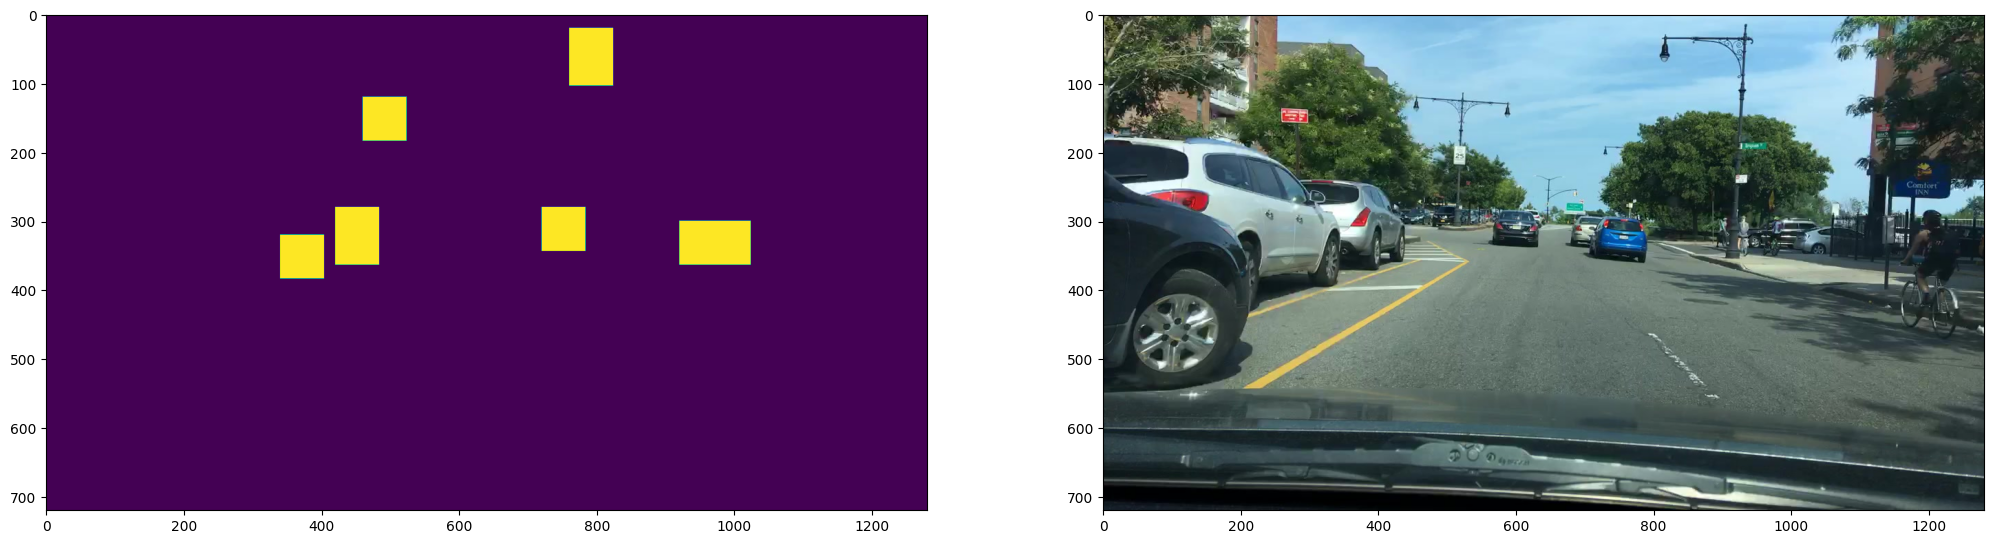

In [82]:
import cv2
import numpy as np

# Load image and boxes
img = cv2.imread("train/A_001.jpg")

# Create heatmap
def create_map(boxes):
    heatmap = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)
    for x,y, w, h in boxes:
        heatmap[y:y+h,x:x+w] += 1.0

    # Threshold heatmap
    threshold = 1
    heatmap[heatmap < threshold] = 0.0
    heatmap[heatmap >= threshold] = 1.0
    return heatmap

def connect_components(heatmap):
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(heatmap.astype(np.uint8))

    # Compute bounding boxes
    bboxes = []
    for i in range(1, num_labels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        width = stats[i, cv2.CC_STAT_WIDTH]
        height = stats[i, cv2.CC_STAT_HEIGHT]
        bboxes.append((x, y, width, height))

    # Merge overlapping bounding boxes
    merged_bboxes = []
    while len(bboxes) > 0:
        bbox = bboxes.pop(0)
        merged_bbox = bbox
        i = 0
        while i < len(bboxes):
            if overlap(merged_bbox, bboxes[i]):
                merged_bbox = merge(merged_bbox, bboxes[i])
                bboxes.pop(i)
            else:
                i += 1
        merged_bboxes.append(merged_bbox)
    return merged_bboxes


heatmap = create_map(boxes)
merged_bboxes = connect_components(heatmap)
print(merged_bboxes)

# Draw bounding boxes on image
#for bbox in merged_bboxes:
 #   cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)


img =  img[:,:,::-1]
# Show image
fig, ax = plt.subplots(1,2, figsize = (25,50))
ax[0].imshow(heatmap)
ax[1].imshow(img)

Many errors

#### TODO:
- change number of hog features for the trained models
- train models on different image sizes -> data exploration

## Increase the number of HOG features to enable better performances

/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator _SigmoidCalibration from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CalibratedClassifierCV from version 1.2.1 whe

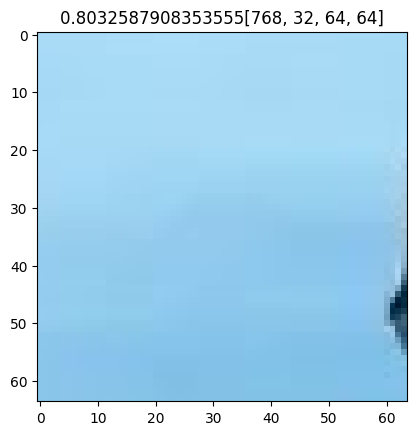

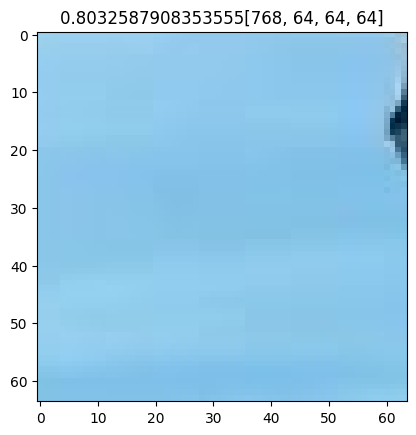

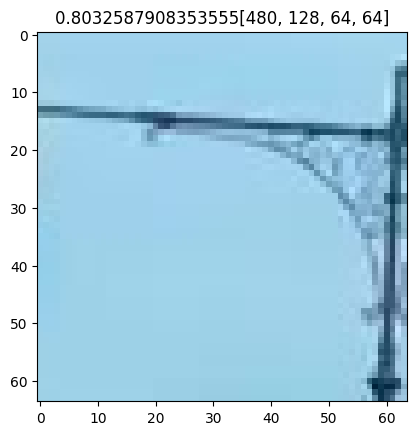

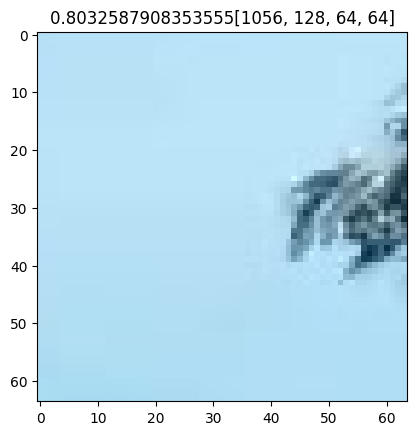

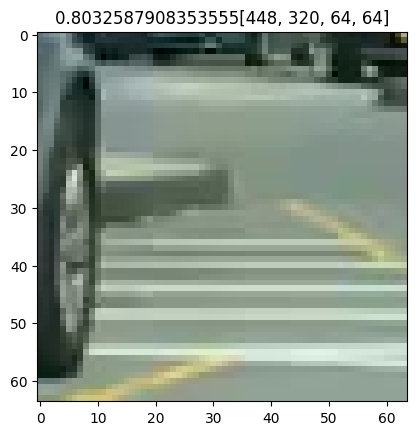

In [45]:
from utils import sliding_window
import numpy as np
import pickle

SVM_PATH = "models/calibratedsvm_33.model"
RDMFOREST_PATH = "models/randomforest_33.model"
model_svm = pickle.load(open(SVM_PATH, "rb"))
model_rdmforest = pickle.load(open(RDMFOREST_PATH, "rb"))
image = cv2.imread("train/A_001.jpg")[:,:,::-1]

boxes = []

for window, coords in sliding_window(image, stride=32, padding = 20):
    fd, hog_image = hog(window, orientations=9, pixels_per_cell=(3, 3),
    cells_per_block=(2, 2), visualize=True,channel_axis=-1)

    fd = fd.reshape(-1, 1)
    fd = np.transpose(fd,(1,0))
    
    proba_svm = model_svm.predict_proba(fd)
    proba_rdmforest = model_rdmforest.predict_proba(fd)

    # If there is likely a car, print it
    if proba_svm[0][1] > 0.7 and proba_rdmforest[0][1] > 0.7 :
        plt.title(str(proba[0][1])+ str([coords[0],coords[1], coords[2], coords[3]]))
        plt.imshow(window)
        plt.show()
        boxes += [coords[0],coords[1] , coords[2], coords[3]]

In [46]:
df_boxes = create_bounding_boxes_df(boxes)
interact(f_display, frame_id=widgets.IntSlider(min=0, max=N-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='frame_id', max=2221), Output()), _dom_classes=('widget-i…

<function __main__.f_display(frame_id)>

In [38]:
from utils import sliding_window
import numpy as np
import pickle

MODEL_PATH = "models/randomforest_33.model"
model = pickle.load(open(MODEL_PATH, "rb"))
image = cv2.imread("train/A_001.jpg")[:,:,::-1]

boxes = []

for window, coords in sliding_window(image, stride=32, padding=20):
    #proba = model.predict_proba(fd)

    # If there is likely a car, print it
    boxes += [coords[0],coords[1] , coords[2], coords[3]]

df_boxes = create_bounding_boxes_df(boxes)
interact(f_display, frame_id=widgets.IntSlider(min=0, max=N-1, step=1, value=0))

/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


interactive(children=(IntSlider(value=0, description='frame_id', max=2221), Output()), _dom_classes=('widget-i…

<function __main__.f_display(frame_id)>

In [39]:
df_boxes = create_bounding_boxes_df(boxes)

interact(f_display, frame_id=widgets.IntSlider(min=0, max=N-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='frame_id', max=2221), Output()), _dom_classes=('widget-i…

<function __main__.f_display(frame_id)>